<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Realização da Análise Exploratória de Dados de Logística da empresa Loggi utilizando a região de Brasilia-DF.

Abaixo estão situados todo o passo a passo da construção das linhas de código, construção dos gráficos, análise das situações e suas possiveis soluções.

## 2\. Pacotes e bibliotecas

In [1]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
#
# - 1º pacotes nativos do python: json, os, etc.;
# - 2º pacotes de terceiros: pandas, seabornm etc.;
# - 3º pacotes que você desenvolveu.
#

!pip install geopy
!pip install geopandas
!pip install geobr
!pip install descartes

import pandas as pd
import requests
import seaborn as sns
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.1/928.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.2
    Uninstalling shapely-2.0.2:
      Successfully uninstalled shapely-2.0.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.10.0 requires geopandas>=0.12.2, but you have geopandas 0.7.0 which is incompatible.


## 3\. Exploração de dados

In [2]:
# faça o código de exploração de dados:
#
# - coleta de dados;
# - wrangling da estrutura;
# - exploração do schema;
# - etc.


url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'
nome_arquivo = 'deliveries.json'
aux = requests.get(url)
with open(nome_arquivo, 'wb') as fp:
    fp.write(aux.content)

url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
nome_arquivo = 'deliveries-geodata.csv'
aux = requests.get(url)
with open(nome_arquivo, 'wb') as fp:
    fp.write(aux.content)

df_bases = pd.read_json("deliveries.json")
df_entregas = pd.read_csv("deliveries-geodata.csv", header = 0)

## 4\. Manipulação

In [3]:
# faça o código de manipulação de dados:
#
# - enriquecimento;
# - controle de qualidade;
# - etc.

df_bases = pd.merge(left=df_bases, right=df_entregas, how="inner", left_index=True, right_index=True)
df_bases_normalized= pd.json_normalize(df_bases["origin"])
df_bases = pd.merge(left=df_bases, right=df_bases_normalized, how="inner", left_index=True, right_index=True)

df_bases = df_bases.drop(["origin", "delivery_lat", "delivery_lng"], axis=1)
df_bases = df_bases.rename(columns={
"name":"Nome",
"region": "Base",
"vehicle_capacity":"Capacidade_Veiculo",
"deliveries":"Entregas",
"lng":"lng_base",
"lat":"lat_base",
"delivery_city": "Cidade_entrega",
"delivery_suburb":"Região_entrega"
})

df_bases = df_bases[["Nome", "Base", "lng_base", "lat_base", "Cidade_entrega", "Região_entrega","Capacidade_Veiculo", "Entregas"]]
bases_exploded = df_bases[["Entregas"]].explode("Entregas")
bases_exploded = pd.concat([
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["size"])).rename(columns={"Entregas":"Tamanho_Entrega"}),
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lng"])).rename(columns={"Entregas":"lng_entrega"}),
    pd.DataFrame(bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lat"])).rename(columns={"Entregas":"lat_entrega"}),
],axis=1)

df_bases = df_bases.drop("Entregas", axis=1)
df_bases = pd.merge(left=df_bases, right=bases_exploded, how="right", left_index=True, right_index=True)
df_bases.reset_index(inplace=True, drop=True)

#Método fillna para detectar e remover valores nulos.
df_bases[["Cidade_entrega", "Região_entrega"]] = df_bases[["Cidade_entrega", "Região_entrega"]].fillna("Indisponível")

## 5\. Visualização

In [4]:
# faça o código de visualização de dados:
#
# - produza pelo menos duas visualizações;
# - adicione um pequeno texto com os insights encontrados;
# - etc.

mapa_distrito_federal = geobr.read_municipality(code_muni='DF', year=2020)

geo_base = df_bases[["Base", "lng_base", "lat_base"]].drop_duplicates().reset_index(drop= True)
geo_base_df = gpd.GeoDataFrame( geo_base, geometry=gpd.points_from_xy( geo_base["lng_base"], geo_base["lat_base"] ) )

geo_entregas_df = gpd.GeoDataFrame(df_bases, geometry=gpd.points_from_xy(df_bases["lng_entrega"], df_bases["lat_entrega"]))

total_entregas = df_bases['Tamanho_Entrega'].sum()

total_entregas_base = df_bases[['Base', 'Tamanho_Entrega']].groupby("Base").agg("sum").reset_index()
total_entregas_base ['porcentagem_total_entregas'] = round(total_entregas_base ['Tamanho_Entrega'] / total_entregas, 2)
total_entregas_base.rename(columns={'Tamanho_Entrega':'total_base', "Base":"região"}, inplace=True)
total_entregas_base

rank_cidades_entregas = df_bases["Cidade_entrega"].value_counts().reset_index()
rank_cidades_entregas.rename(columns={"index":"cidade", "Cidade_entrega": "qtd_entregas"}, inplace=True)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.10/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


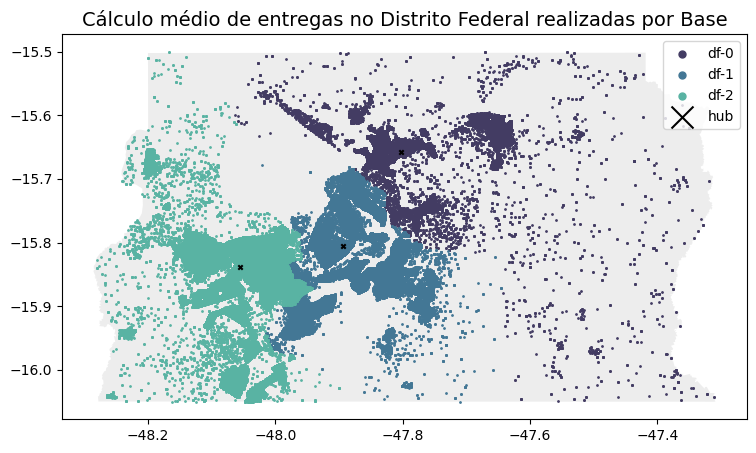

In [5]:
grafico, ax = plt.subplots(figsize=(10, 5))
mapa_distrito_federal.plot(ax=ax, alpha=0.4, color="lightgrey")
geo_entregas_df.query("Base == 'df-0'").plot(ax=ax, markersize=1, color="#433c63", label="df-0")
geo_entregas_df.query("Base == 'df-1'").plot(ax=ax, markersize=1, color="#437795", label="df-1")
geo_entregas_df.query("Base == 'df-2'").plot(ax=ax, markersize=1, color="#59b3a3", label="df-2")
geo_base_df.plot( ax=ax, markersize=10, marker="x", color="black", label="hub" )
plt.title( "Cálculo médio de entregas no Distrito Federal realizadas por Base", fontdict={"fontsize": 14} )
legenda_grafico = plt.legend(prop={"size": 10}, markerscale=5, loc="upper right")

1° Insight:

Há uma grande proporção de entregas distantes realizadas na região representada em tom aproximado violeta(df-0), se esse fluxo aumentar, construir uma nova base central às regiões distantes auxiliará em um controle melhor da região mapeada.

<ipython-input-6-ecf2ed9536fd>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='mako')


[Text(0.5, 1.0, 'Entregas realizadas por base'),
 Text(0.5, 0, 'Bases'),
 Text(0, 0.5, 'Volume de entregas')]

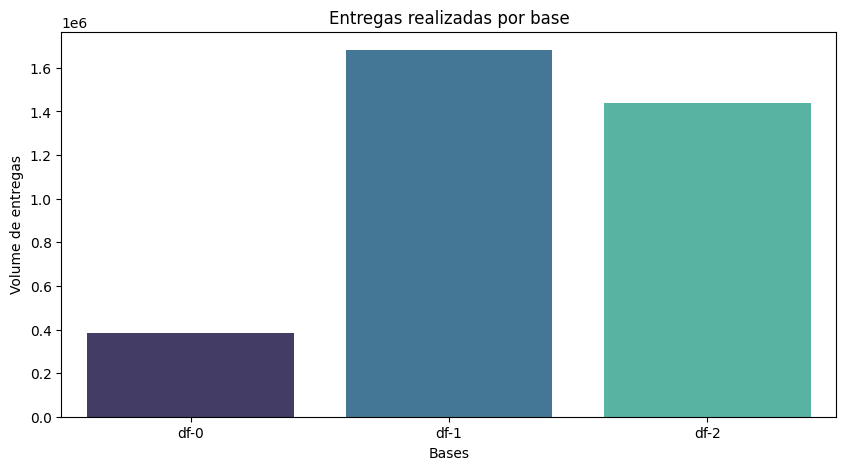

In [6]:
grafico_1 = plt.figure(figsize=(10, 5))
total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='mako')
total_entregas_grafico.set(title='Entregas realizadas por base', xlabel='Bases', ylabel='Volume de entregas')

2° Insight:

Analisando o gráfico podemos notar que, devido à grande distância entre as entregas efetuadas, a região em tom aproximado violeta(df-0) se posiciona em um valor menor às outras duas regiões proximas(df-1 e df-2).

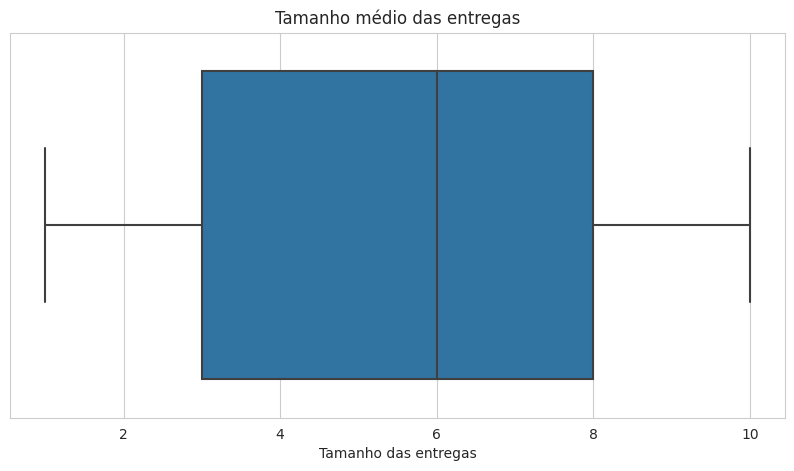

In [7]:
with sns.axes_style("whitegrid"):
  grafico_2 = plt.figure(figsize=(10, 5))
  grafico_tamanho_entregas = sns.boxplot(x=df_bases["Tamanho_Entrega"])
  grafico_tamanho_entregas.set(title="Tamanho médio das entregas", xlabel="Tamanho das entregas")

3° Insight:

É possivel notar que há uma média aproximada de entregas com tamanhos que variam de 3 à 8, podendo-se notar que existem entregas com tamanhos entre aproximadamente 0,70 a 3 e de 8 a 10, mas que essas já não são comuns e acabam por sair da zona de cálculo médio.